In [47]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt

import torch
def generate_gaussian_heatmap_batch(centers_sizes, sigma=6, grid_size=(128, 128, 128)):
    """
    Generate a batch of 3D Gaussian heatmaps from a batch of centers and sizes.
    :param centers_sizes: Tensor of shape (batch_size, 6) containing [x, y, z, w, h, d] for each sample
    :param sigma: Gaussian distribution's sigma
    :param grid_size: tuple(width, height, depth) of the heatmap grid
    :return: Batch of 3D heatmaps as a tensor
    """
    # Extract centers and sizes
    centers = centers_sizes[:, :3]  # Get x, y, z for each batch
    # sizes = centers_sizes[:, 3:]  # Not directly used in Gaussian, but could be used to adjust sigma

    # Create meshgrid
    z = torch.arange(0, grid_size[2], dtype=torch.float32, device=centers.device)
    y = torch.arange(0, grid_size[1], dtype=torch.float32, device=centers.device)
    x = torch.arange(0, grid_size[0], dtype=torch.float32, device=centers.device)
    xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')
    # print(zz.shape, yy.shape, xx.shape)

    # Expand grid to batch size
    xx = xx.expand(centers.size(0), *xx.size())
    yy = yy.expand(centers.size(0), *yy.size())
    zz = zz.expand(centers.size(0), *zz.size())

    # Subtract center coordinates for the Gaussian formula
    cx, cy, cz = centers[:, 0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), \
        centers[:, 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), \
        centers[:, 2].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

    # Calculate the heatmap using Gaussian formula
    heatmap = torch.exp(-((xx - cx) ** 2 + (yy - cy) ** 2 + (zz - cz) ** 2) / (2 * sigma ** 2))

    return heatmap

In [9]:
with open('./results/results.json', 'r')as f:
    data = json.load(f)

In [41]:

d.keys()

dict_keys(['img', 'gtbox', 'pred_bbox', 'IoU', 'center_dist'])

(1, 1, 128, 128, 128)

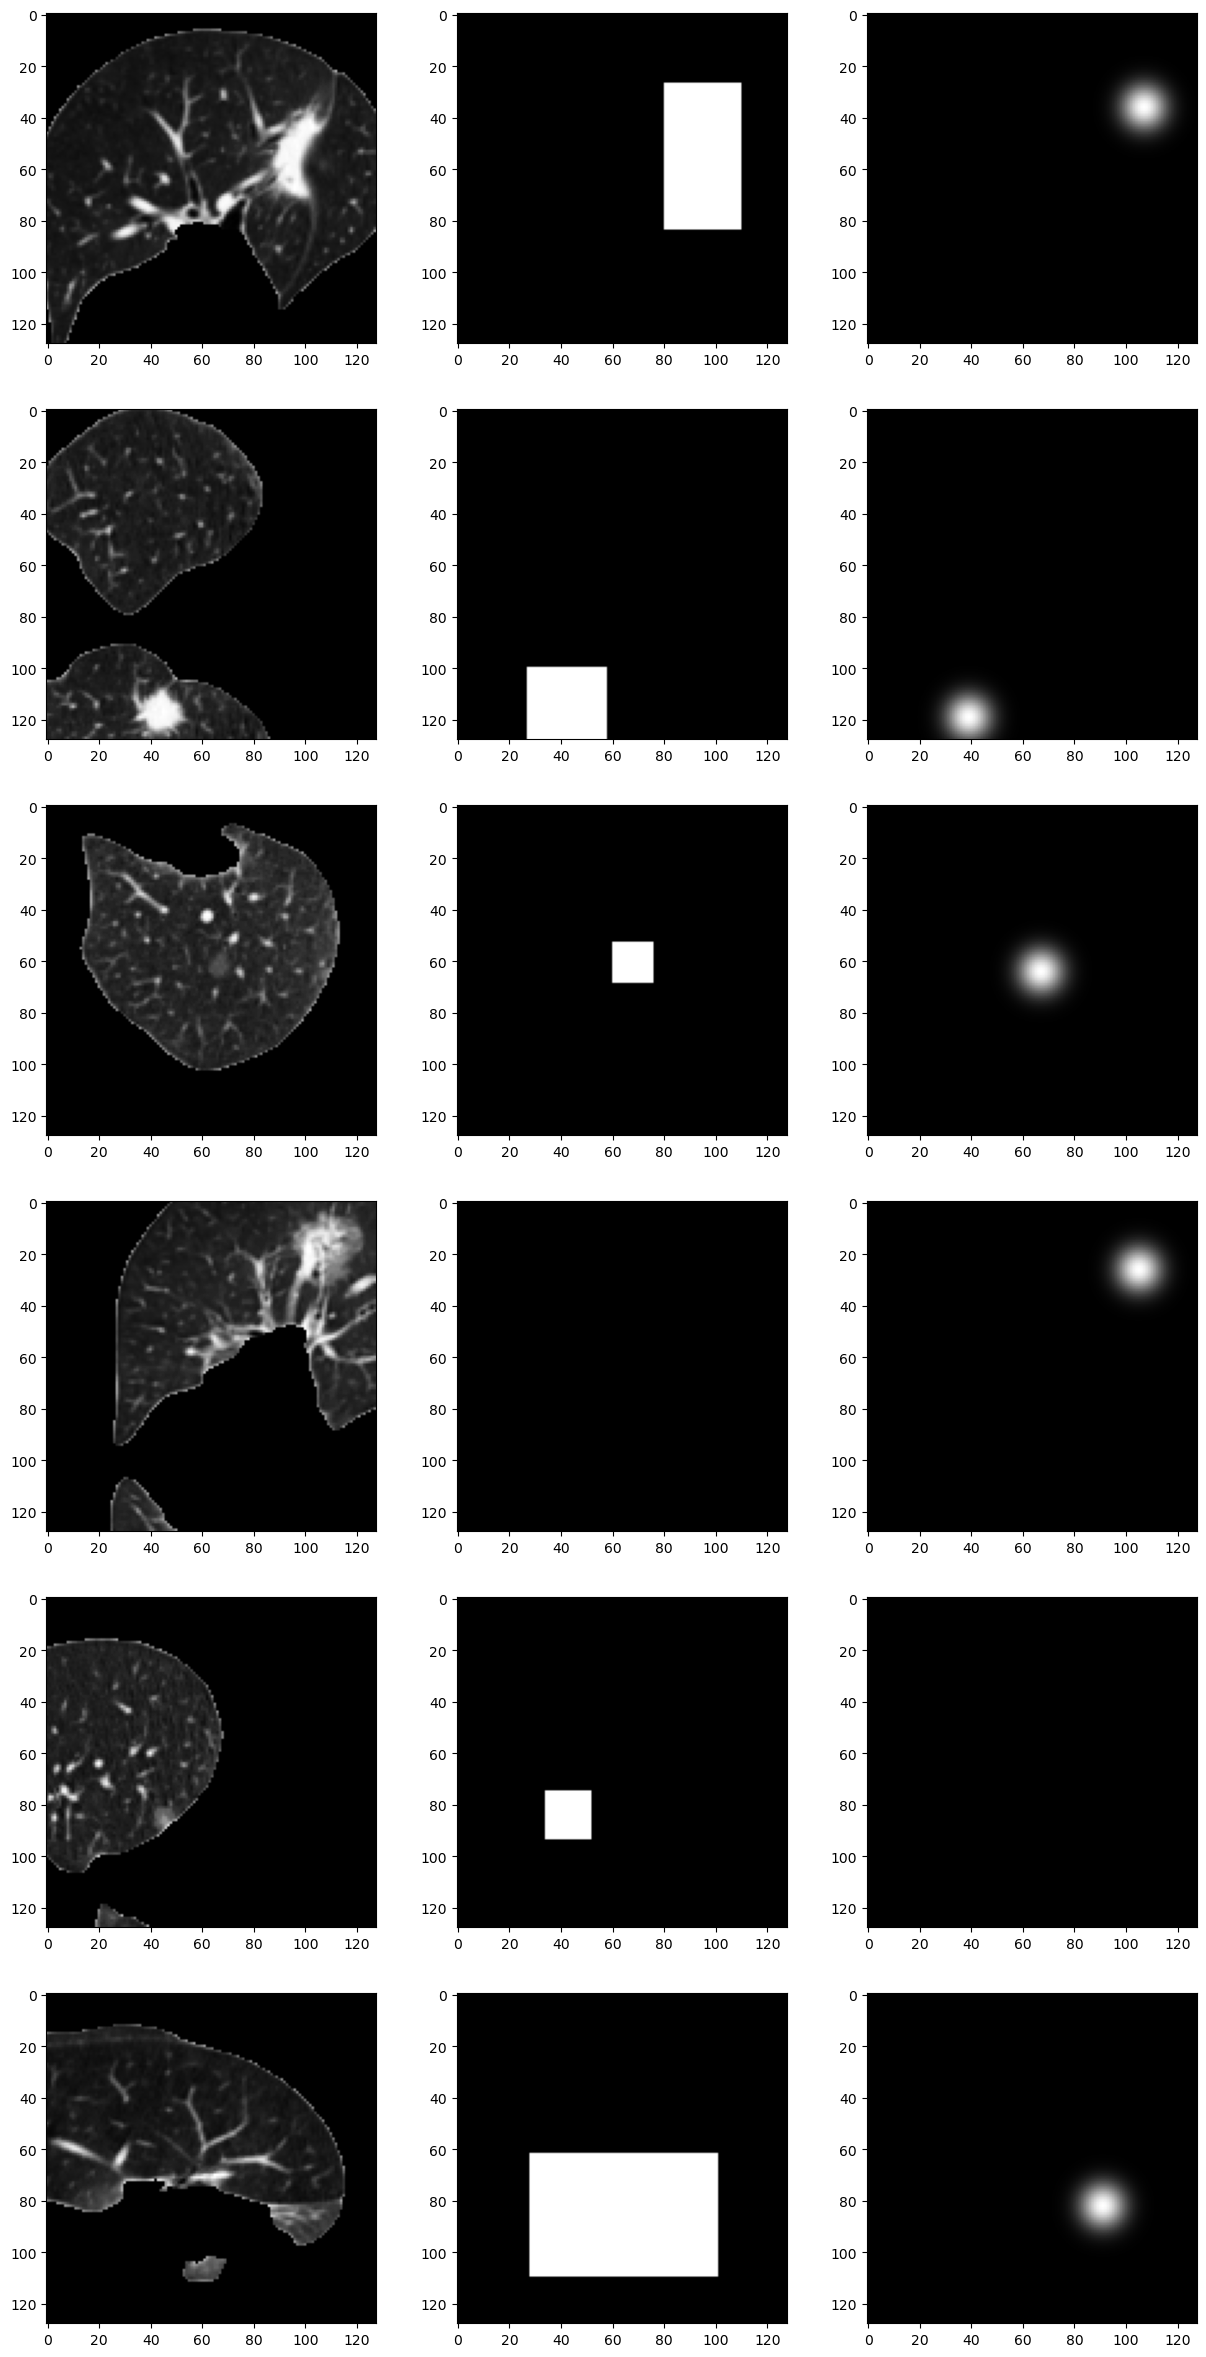

In [58]:
n = len(data)
plt.figure(figsize=(15, 5 * n))
for i in range(n):
    d = data[i]
    img = np.array(d['img'])
    gt = d['gtbox'][0]
    pred = d['pred_bbox']
    IoU = d['IoU']
    center_dist = d['center_dist']
    d = int(gt[2])
    heat_map = generate_gaussian_heatmap_batch(torch.tensor(pred))
    plt.subplot(n, 3, 3*i+1)
    plt.imshow(img[0, 0, :, :, d], cmap='gray')
    plt.subplot(n, 3, 3*i+2)
    array_mask = np.zeros_like(img[0][0])
    array_mask[int(gt[0]-gt[3]/2):int(gt[0]+gt[3]/2), int(gt[1]-gt[4]/2):int(gt[1]+gt[4]/2), int(gt[2]-gt[5]/2):int(gt[2]+gt[5]/2)] = 1
    plt.imshow(array_mask[:, :, d][:], cmap='gray')
    plt.subplot(n, 3, 3*i+3)
    plt.imshow(heat_map[0][:, :, d][:], cmap='gray')

In [51]:
gt, pred, IoU, center_dist

([86.5, 65.0, 60.0, 48.0, 73.0, 73.0],
 [[82, 91, 55, 20, 20, 20]],
 0.03127541020512581,
 26.856098175048828)

In [31]:
array_mask.shape

(128, 128, 128)

In [54]:
help(plt.subplot)

Help on function subplot in module matplotlib.pyplot:

subplot(*args, **kwargs) -> 'Axes'
    Add an Axes to the current figure or retrieve an existing Axes.
    
    This is a wrapper of `.Figure.add_subplot` which provides additional
    behavior when working with the implicit API (see the notes section).
    
    Call signatures::
    
       subplot(nrows, ncols, index, **kwargs)
       subplot(pos, **kwargs)
       subplot(**kwargs)
       subplot(ax)
    
    Parameters
    ----------
    *args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
        The position of the subplot described by one of
    
        - Three integers (*nrows*, *ncols*, *index*). The subplot will take the
          *index* position on a grid with *nrows* rows and *ncols* columns.
          *index* starts at 1 in the upper left corner and increases to the
          right. *index* can also be a two-tuple specifying the (*first*,
          *last*) indices (1-based, and including *last*) of 

In [59]:
d = data[-3]
d['gtbox']

[[10.5, 107.0, 82.0, 41.5, 51.0, 62.0]]

In [2]:
# 影像组学特征
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor
import os
import pandas as pd

In [3]:
settings = {}
# settings['binWidth'] = 25
settings['resampledPixelSpacing'] = None  # [3,3,3] is an example for defining resampling (voxels with size 3x3x3mm)
# settings['interpolator'] = sitk.sitkBSpline

In [11]:
data_dir = '/home/zcd/datasets/LungCancer/LC0710/nnUnetDataset/sitk128'
radiomics_features = []
for filename in filter(lambda x: 'nii.gz' in x, os.listdir(data_dir)):
    # filename = 'P006464_0075.nii.gz'
    imageName, maskName = os.path.join(data_dir, filename), os.path.join(data_dir.replace('sitk128', 'segmentation'), filename.replace('_0000', ''))
    dic = {'bid': filename.split('_')[1]}
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    # extractor.disableAllFeatures()
    # extractor.disableAllImageTypes()
    extractor.enableAllFeatures()
    # print("Calculating features")
    try:
        featureVector = extractor.execute(imageName, maskName)
        
        for featureName in featureVector.keys():
            if featureName.startswith('original'):
                dic[featureName] = featureVector[featureName]
    except Exception as e:
        print(e)
    radiomics_features.append(dic)
    # break
            # print("Computed %s: %s" % (featureName, featureVector[featureName]))
# imageName, maskName   

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

mask has too few dimensions (number of dimensions 1, minimum required 2)


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum

No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction


No labels found in this mask (i.e. nothing is segmented)!


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


No labels found in this mask (i.e. nothing is segmented)!
No labels found in this mask (i.e. nothing is segmented)!


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

In [18]:
featureVector.keys()

odict_keys(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColum

In [13]:
feats = pd.DataFrame(radiomics_features)
feats

,bid,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,P015861,0.469091,0.459501,14.296486,31.113041,33.24154027718932,32.984845004941285,18.681541692269406,33.97057550292606,2953.9166666666665,...,237.6143699361593,0.01793848307019318,6.676566332837535,0.2618328298086606,565.6839891518737,1.4877087280881143,0.0032040785189924484,1374.2835214318452,0.2076602875118845,4.159427158959134
1,P038515,0.204201,0.081855,10.710436,130.847189,30.59411708155671,29.274562336608895,87.04596486914255,95.29428104561154,1279.7916666666667,...,217.13166671153343,0.010744862024145511,6.523027383726585,0.2074468085106383,311.6124729970884,0.30015802540353,0.008787836733960787,1145.7770769313918,0.26445369200692415,13.779219730361389
2,P030456,0.850070,0.668387,11.629080,17.398733,17.08800749063506,21.2602916254693,17.08800749063506,21.61018278497431,1996.4166666666667,...,143.09164702180456,0.010652225164385718,6.486858036598936,0.256575682382134,166.3241135998863,0.985227122165299,0.005632800936456637,865.2870985704654,0.19336383126769735,2.7680309561529
3,P076761-1,0.299292,0.264703,9.340629,35.287205,32.7566787083184,33.52610922848042,12.529964086141668,33.66006535941367,2099.2916666666665,...,85.65093515593665,0.01046404280406481,5.96639271541633,0.11357210179076344,1987.7254523854615,1.1178334966907946,0.004317020784818573,360.23730245700284,0.033606733814595544,2.95075271926441
4,P037760,0.358469,0.280255,8.516573,30.388629,29.410882339705484,28.635642126552707,14.317821063276353,29.427877939124322,1566.7916666666667,...,120.87430234887505,0.025541479196394854,5.742410559995636,0.1277533039647577,2852.6451503312387,1.2367830881126889,0.004287245922378775,751.6350930397023,0.036082564730517415,12.365720891747431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,P042035-2,0.451229,0.339119,8.320900,24.536809,29.068883707497267,29.017236257093817,14.560219778561036,29.171904291629644,1037.625,...,194.31737373834875,0.009513197073757423,6.11251392915947,0.15819209039548024,843.8966836734694,0.4563504766291892,0.01121868306167655,635.5861131866557,0.08254798318217867,19.285574084203045
1610,P010492,0.311686,0.226376,7.993563,35.311018,32.7566787083184,32.55764119219941,13.601470508735444,33.36165463522455,1199.5833333333333,...,160.09306635454345,0.013212761915923125,6.452414587345089,0.23491027732463296,205.09370177469134,0.6141883110522138,0.009782939133750664,824.9240002552264,0.13835844970685285,8.49068384501963
1611,P034201,0.310858,0.292368,4.124693,14.107870,18.110770276274835,18.24828759089466,5.0990195135927845,18.275666882497067,101.29166666666667,...,8.69526798105062,0.0671604428667541,3.7216117239698963,0.16964285714285715,84.62049861495844,1.3101501199492223,0.05920109893422915,16.361590569097732,0.057252014575446646,1.382912162168603
1612,P002987-1,0.282897,0.262261,8.829087,33.665291,32.7566787083184,32.984845004941285,12.36931687685298,33.13608305156178,1571.875,...,79.03975045982818,0.0161709126911857,6.061027440206658,0.16416040100250626,409.6099294912884,0.8183529567978917,0.005845363390039319,432.2978372961026,0.04800551636696455,2.8379548144764284


In [14]:
feats['original_shape_Elongation'].isna().sum()

125

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_standardize = feats.columns.tolist()[1:]
feats[columns_to_standardize] = scaler.fit_transform(feats[columns_to_standardize])
feats

,bid,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,P015861,0.346923,0.736602,2.063359,0.074820,0.848983,0.801763,0.664231,0.373063,1.694210,...,0.612047,-0.261322,1.049424,0.503792,-0.157054,0.142068,-0.334724,0.449899,0.160240,-0.390621
1,P038515,-0.888682,-1.399543,0.837948,6.258824,0.492484,0.308272,8.968827,5.607183,-0.014798,...,0.466488,-0.492529,0.840461,-0.048455,-0.412466,-0.179295,-0.190333,0.258472,0.360796,0.318451
2,P030456,2.124031,1.918154,1.151864,-0.775534,-1.326231,-0.757678,0.470656,-0.681925,0.716759,...,-0.059672,-0.495507,0.791235,0.450410,-0.558521,0.006091,-0.271919,0.023497,0.109755,-0.493180
3,P076761-1,-0.445120,-0.365268,0.369864,0.333639,0.783692,0.873755,-0.083034,0.346561,0.821778,...,-0.467871,-0.501555,0.082895,-1.001680,1.272492,0.041976,-0.305944,-0.399598,-0.454398,-0.479712
4,P037760,-0.169083,-0.277297,0.088271,0.029903,0.333152,0.223291,0.134146,-0.014666,0.278182,...,-0.217558,-0.016958,-0.221939,-0.857681,2.141976,0.074165,-0.306714,-0.071712,-0.445655,0.214262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,P042035-2,0.263603,0.055664,0.021406,-0.332938,0.287098,0.274046,0.163592,-0.036514,-0.262010,...,0.304360,-0.532116,0.281762,-0.548598,0.122627,-0.137028,-0.127473,-0.168930,-0.281571,0.724322
1610,P010492,-0.387310,-0.582063,-0.090450,0.335115,0.783692,0.744943,0.047127,0.321090,-0.096678,...,0.061147,-0.413210,0.744359,0.230415,-0.519547,-0.094315,-0.164600,-0.010316,-0.084486,-0.071365
1611,P034201,-0.391172,-0.208780,-1.412505,-0.979583,-1.188507,-1.158294,-0.985711,-0.966533,-1.217854,...,-1.014752,1.320697,-2.972197,-0.432325,-0.640656,0.094019,1.113313,-0.687673,-0.370899,-0.595277
1612,P002987-1,-0.521595,-0.379082,0.195061,0.233072,0.783692,0.801763,-0.102549,0.301837,0.283371,...,-0.514853,-0.318133,0.211690,-0.487995,-0.313952,-0.039066,-0.266423,-0.339231,-0.403551,-0.488026


In [16]:
feats['original_shape_Elongation'].isna().sum()

125

In [17]:
feats.to_csv('/home/zcd/datasets/LungCancer/LC0710/radiomics.csv', index=0)